In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

year = 2022

In [3]:
url = f'https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Activiteit?$filter=contains(soort,%27plenair%20debat%27)%20and%20Status%20eq%20%27Uitgevoerd%27%20and%20year(Datum)%20eq%20{year}&$count=true'
all_debates = []

while url:
    response = requests.get(url)
    data = response.json()
    debates = data.get("value", [])

    all_debates.extend(debates)

    url = data.get("@odata.nextLink", None)

df = pd.DataFrame(all_debates)

df.to_csv(f"data/debates_{year}.csv", index=False)

In [4]:
url = f'https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming?$filter=year(GewijzigdOp)%20eq%20{year}'
all_votings = []
while url:
    response = requests.get(url)
    
    data = response.json()
    votings = data.get("value", [])
    all_votings.extend(votings)

    url = data.get("@odata.nextLink", None)

df = pd.DataFrame(all_votings)

df.to_csv(f"data/votings_{year}.csv", index=False)

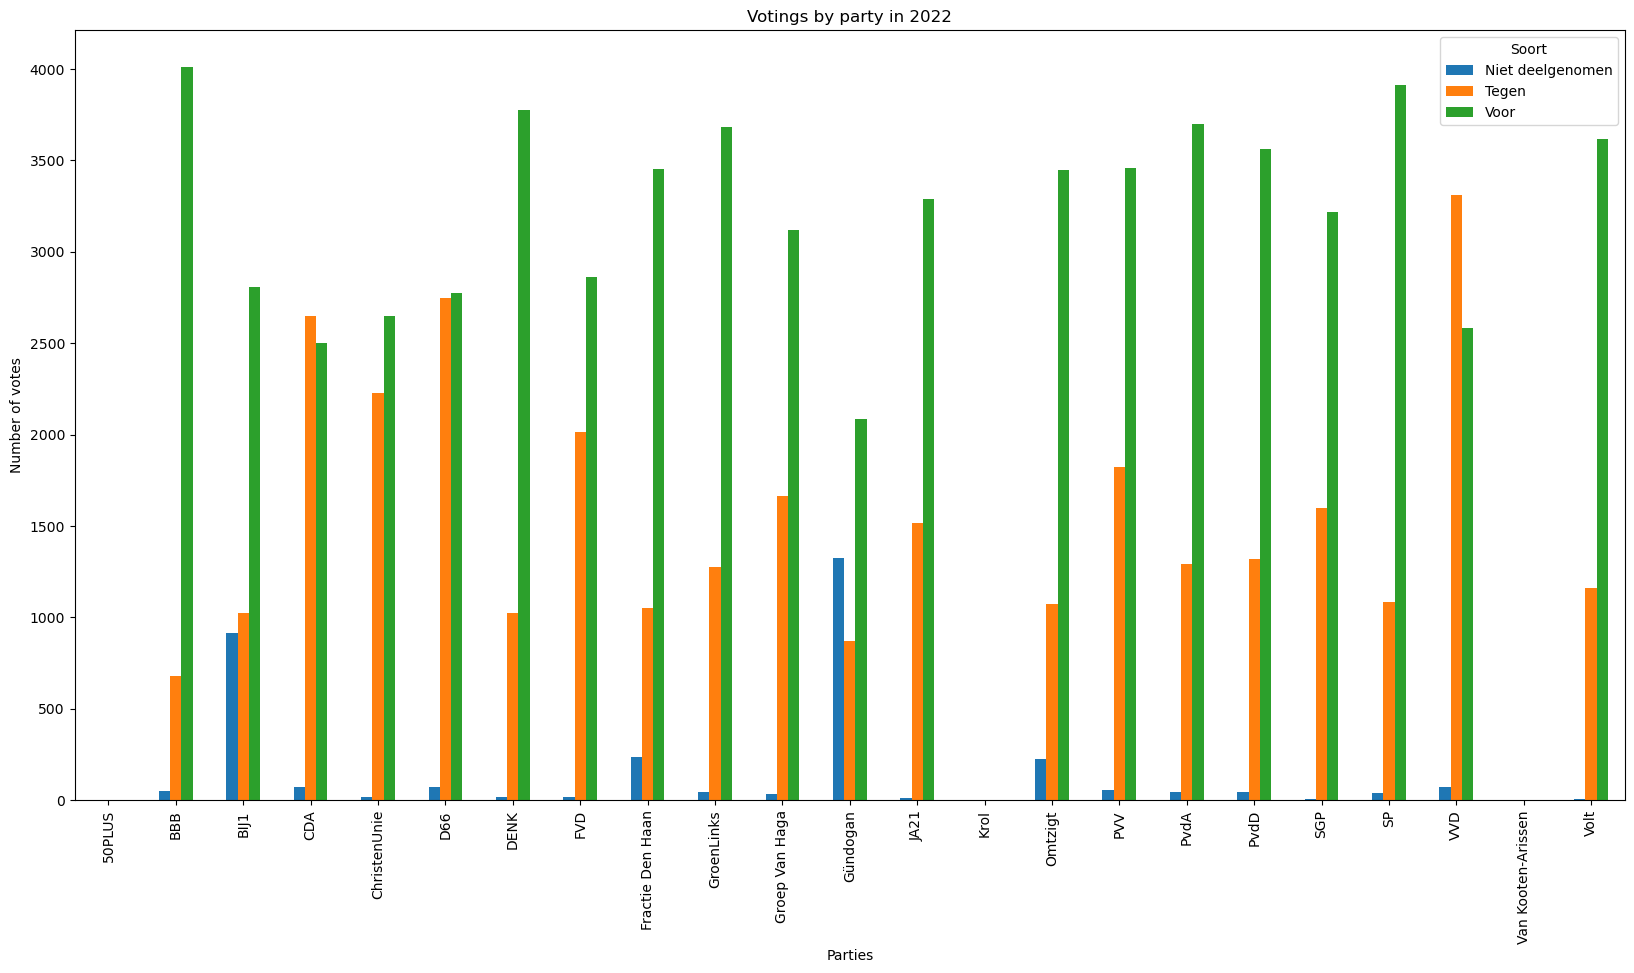

In [5]:
# Plot Soort by ActorFractie

df = pd.read_csv(f"data/votings_{year}.csv")

df.groupby(["ActorFractie", "Soort"]).size().unstack().plot(kind='bar', stacked=False, figsize=(20, 10))
plt.title(f"Votings by party in {year}")
plt.xlabel("Parties")
plt.ylabel("Number of votes")
plt.show()


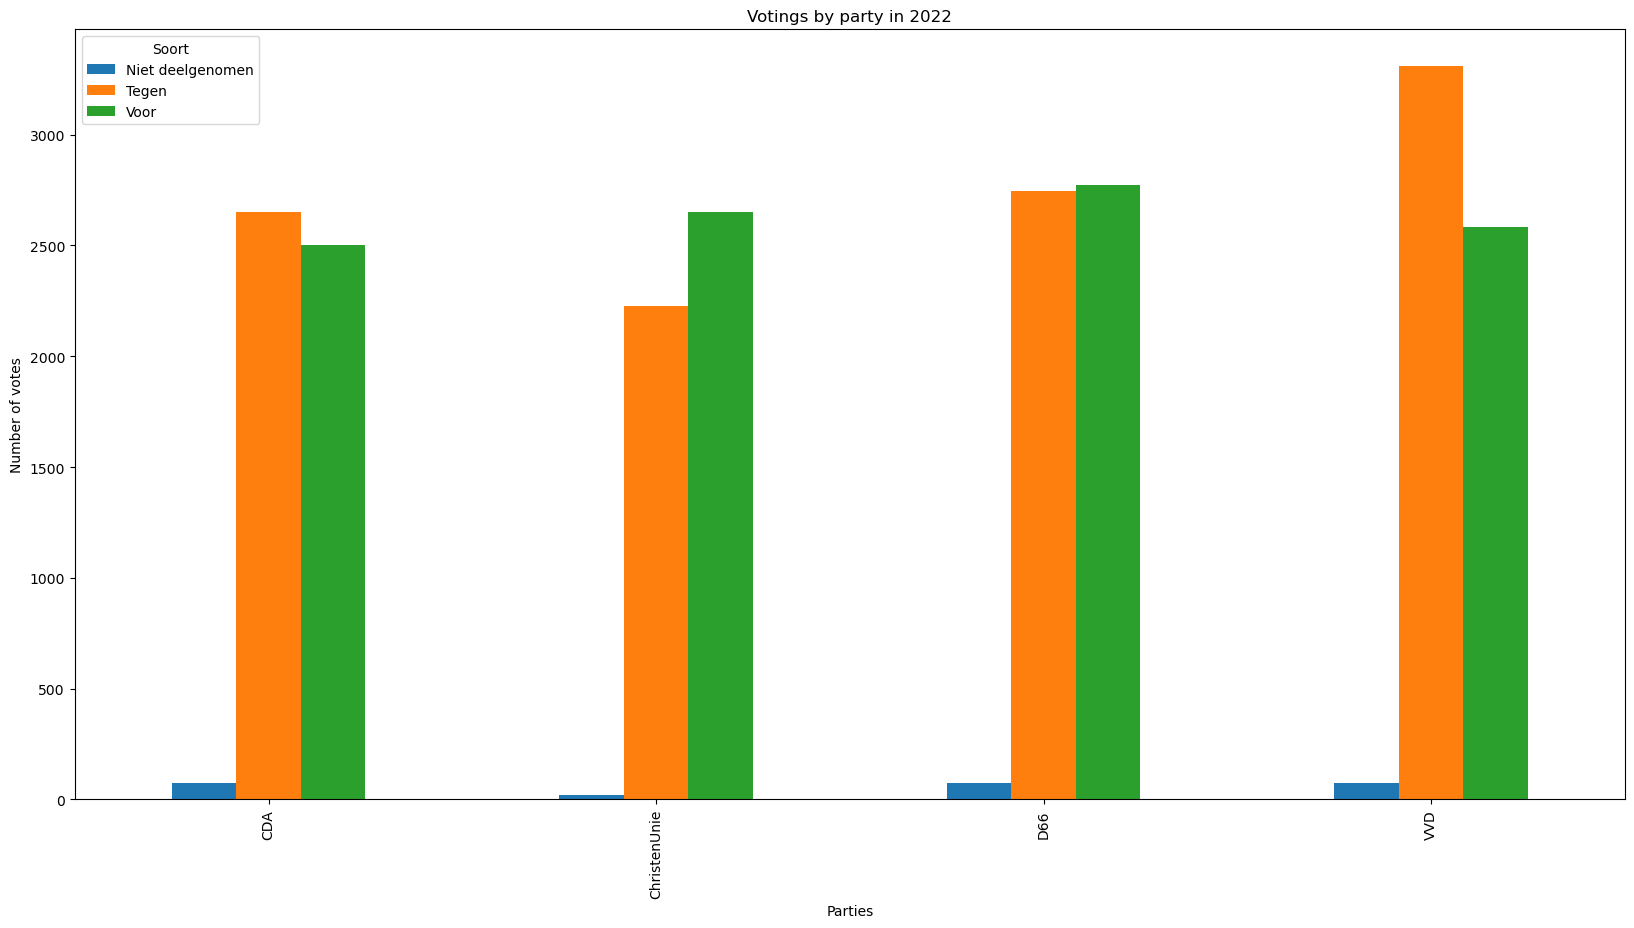

In [6]:
# Plot Soort by ActorFractie

df = pd.read_csv(f"data/votings_{year}.csv")
# Only select VVD, CU, CDA, D66
df = df[df['ActorFractie'].isin(['VVD', 'ChristenUnie', 'CDA', 'D66'])]

df.groupby(["ActorFractie", "Soort"]).size().unstack().plot(kind='bar', stacked=False, figsize=(20, 10))
plt.title(f"Votings by party in {year}")
plt.xlabel("Parties")
plt.ylabel("Number of votes")
plt.show()



Number of motions with variable votes: 843
Number of rows in original dataset: 21680


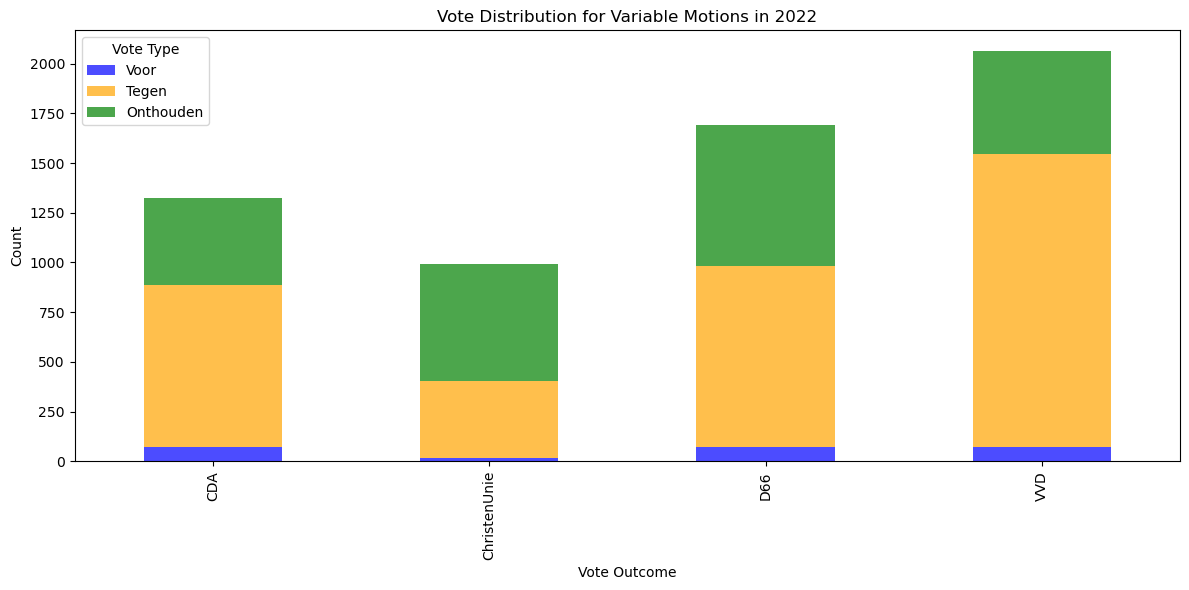

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(f"data/votings_{year}.csv")

# Filter for specific parties
parties = ['VVD', 'ChristenUnie', 'CDA', 'D66']
df = df[df['ActorFractie'].isin(parties)]


# Convert 'Soort' into numeric values (adjust mapping as needed)
soort_mapping = {"Voor": 1, "Tegen": -1, "Niet deelgenomen": 0}  # Example mapping
df["Soort_numeric"] = df["Soort"].map(soort_mapping)

# Identify motions where 'Soort' is NOT the same for all selected parties
motion_votes = df.groupby("Besluit_Id")["Soort_numeric"].nunique()  # Count unique votes per motion
variable_motions = motion_votes[motion_votes > 1].index  # Keep only motions with different votes

# Filter dataset to only keep those motions
df_filtered = df[df["Besluit_Id"].isin(variable_motions)]

# Count how many motions df_filtered has vs. df
print(f"Number of motions with variable votes: {len(variable_motions)}")
print(f"Number of rows in original dataset: {len(df)}")

vote_counts = df_filtered.groupby(["ActorFractie", "Soort"]).size().unstack(fill_value=0)

# Plot the distribution of votes for each party
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each party's votes (use different colors for each)
vote_counts.plot(kind="bar", stacked=True, ax=ax, color=['blue', 'orange', 'green', 'red'], alpha=0.7)

# Customize chart
ax.set_title(f"Vote Distribution for Variable Motions in {year}")
ax.set_xlabel("Vote Outcome")
ax.set_ylabel("Count")
ax.legend(title="Vote Type", labels=["Voor", "Tegen", "Onthouden"])  # Customize legend for Soort values

plt.tight_layout()
plt.show()


In [8]:
from itertools import combinations

# Look which of the four parties voted the most against the other three
df = pd.read_csv(f"data/votings_{year}.csv")

# Filter for specific parties
parties = ['VVD', 'ChristenUnie', 'CDA', 'D66']
df = df[df['ActorFractie'].isin(parties)]

# Convert 'Soort' into numeric values (adjust mapping as needed)
soort_mapping = {"Voor": 1, "Tegen": -1, "Niet deelgenomen": 0}  # Example mapping

df["Soort_numeric"] = df["Soort"].map(soort_mapping)

# Identify motions where 'Soort' is NOT the same for all selected parties
motion_votes = df.groupby("Besluit_Id")["Soort_numeric"].nunique()  # Count unique votes per motion

variable_motions = motion_votes[motion_votes > 1].index  # Keep only motions with different votes

# Filter dataset to only keep those motions
df_filtered = df[df["Besluit_Id"].isin(variable_motions)]

# Count the number of times each party voted against the other three
vote_counts = df_filtered.groupby("ActorFractie")["Soort_numeric"].sum()

# Find the party that voted against the other three the most
most_against = vote_counts.idxmin()
votes_against = vote_counts.min()

print(f"The party that voted against the other three the most was {most_against} with {votes_against} votes.")

The party that voted against the other three the most was VVD with -950 votes.


In [9]:
import pandas as pd
from itertools import combinations

# Load data
year = 2022  # Change as needed
df = pd.read_csv(f"data/votings_{year}.csv")

# Filter for specific parties
parties = ['VVD', 'ChristenUnie', 'CDA', 'D66']
df = df[df['ActorFractie'].isin(parties)]

# Convert 'Soort' into numeric values (adjust mapping as needed)
soort_mapping = {"Voor": 1, "Tegen": -1, "Niet deelgenomen": 0}  # Example mapping
df["Soort_numeric"] = df["Soort"].map(soort_mapping)

# Identify motions where 'Soort' is NOT the same for all selected parties
motion_votes = df.groupby("Besluit_Id")["Soort_numeric"].nunique()  # Count unique votes per motion
variable_motions = motion_votes[motion_votes > 1].index  # 

# Filter dataset to only keep those motions
df_filtered = df[df["Besluit_Id"].isin(variable_motions)]

# Ensure there are no duplicates by dropping them (if a party voted more than once on the same motion)
df_filtered = df_filtered.drop_duplicates(subset=["Besluit_Id", "ActorFractie"])

# Create a DataFrame to store the number of disagreements between each pair of parties
disagreement_counts = pd.DataFrame(0, index=parties, columns=parties)

# Iterate over each pair of parties
for party1, party2 in combinations(parties, 2):
    # Filter the DataFrame for votes by the two parties
    df_pair = df_filtered[df_filtered['ActorFractie'].isin([party1, party2])]
    
    # Ensure the index is unique before pivoting
    df_pair = df_pair.reset_index(drop=True)
    
    # Pivot the DataFrame to have one row per motion and one column per party
    pivot_df = df_pair.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort_numeric')
    
    # Drop rows where either party didn't vote (NaN values)
    pivot_df = pivot_df.dropna(subset=[party1, party2])
    
    # Count the number of disagreements (where the product of the votes is -1)
    disagreements = (pivot_df[party1] * pivot_df[party2] == -1).sum()
    
    # Store the count of disagreements in the DataFrame
    disagreement_counts.loc[party1, party2] = disagreements
    disagreement_counts.loc[party2, party1] = disagreements

# Find the pair of parties with the most disagreements
most_disagreements_pair = disagreement_counts.stack().idxmax()
most_disagreements_count = disagreement_counts.stack().max()

print(f"The two parties that disagreed the most with each other were {most_disagreements_pair} with {most_disagreements_count} disagreements.")


The two parties that disagreed the most with each other were ('VVD', 'D66') with 578 disagreements.
